# load essential and useful packages

In [1]:
import numpy as np
import os
import ultranest
import scipy
import corner
import matplotlib.pyplot as plt
import tensorflow.compat.v1 as tf
import time
os.chdir('/scratch/vp91/yq5547/notebooks') # This is my working directory

# let's load the emulator first

In [2]:
emulator = tf.keras.models.load_model('emulator')

2023-06-13 07:53:20.934978: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-13 07:53:20.935040: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (gadi-cpu-bdw-0173.gadi.nci.org.au): /proc/driver/nvidia/version does not exist


again define limits/parameters which can be intuitive

In [3]:
# define the meaning for the features, i.e. your model parameters
parameters = np.array([r"$\log_{10} f_{*,10}$",
                       r"$\alpha_*$",
                       r"$\log_{10} f_{\rm esc, 10}$",
                       r"$\alpha_{\rm esc}$",
                       r"$\log_{10}[M_{\rm turn}/{\rm M}_{\odot}]$",
                       r"$t_*$",
                       r"$\log_{10}\frac{L_{\rm X<2keV}/{\rm SFR}}{{\rm erg\ s^{-1}\ M_{\odot}^{-1}\ yr}}$",
                       r"$E_0/{\rm keV}$",
                       r"$\alpha_{\rm X}$"])
                       
# and their limits
limits = np.array([[-3,0], [-0.5,1], [-3,0],[-1,0.5], [8,10], [0.01,1], [38,42], [0.1,1.5], [-1,3]])

# define prior

In [4]:
def my_prior_transform(cube):
    params = cube.copy()

    for i in range(len(limits)):
        params[i] = cube[i] * (limits[i][1] - limits[i][0]) + limits[i][0]

    return params

# define likelihood

In [5]:
def my_likelihood(theta):
    theta = (np.array(theta) - limits[:,0]) / (limits[:,1] - limits[:,0])

    model = emulator.predict(theta.reshape([1,-1]))[0]
    total_sum = 0
    current_index = 0

    # neutral fraction
    McGreer_NF = model[current_index]
    current_index+=1
    if McGreer_NF>1.:
        McGreer_NF=1 # physical prior

    McGreer_Mean = 0.06
    McGreer_OneSigma = 0.05
    if McGreer_NF>McGreer_Mean:
        total_sum += np.square((McGreer_Mean - McGreer_NF) / McGreer_OneSigma) # 1side Gaussian


    # CMB optical depth
    tau_value = model[current_index]
    current_index+=1

    # Mean and one sigma errors for the Planck constraints, 2006.16828
    PlanckTau_Mean = 0.0569
    PlanckTau_OneSigma_u = 0.0081
    PlanckTau_OneSigma_l = 0.0066
    total_sum += np.square( PlanckTau_Mean - tau_value )/(PlanckTau_OneSigma_u * PlanckTau_OneSigma_l +
                 (PlanckTau_OneSigma_u - PlanckTau_OneSigma_l) * (tau_value - PlanckTau_Mean))     # one way to write likelihood for 2-side Gaussian


    #z=8 21cm PS
    for redshift in [8, 10]:
        k_start = np.fromfile('HERA_Phase1_Limits/k_start_z%d.bin'%redshift, dtype=int)[0]
        ks = slice(k_start-1, None, 2)
        k_limit_vals = np.fromfile('./HERA_Phase1_Limits/PS_limit_ks_z%d.bin'%redshift)
        kwf_limit_vals = np.fromfile('./HERA_Phase1_Limits/PS_limit_kwfs_z%d.bin'%redshift)
        Nkbins = len(k_limit_vals)
        Nkwfbins = len(kwf_limit_vals)
        PS_limit_vals = np.fromfile('./HERA_Phase1_Limits/PS_limit_vals_z%d.bin'%redshift)
        PS_limit_vars = np.fromfile('./HERA_Phase1_Limits/PS_limit_vars_z%d.bin'%redshift)

        ModelPS_val = 10**model[current_index:current_index+len(PS_limit_vals)]
        current_index+=len(PS_limit_vals)

        error_val = np.sqrt(PS_limit_vars + (0.2*ModelPS_val)**2 )
        likelihood = 0.5 + 0.5 * scipy.special.erf( ( PS_limit_vals - ModelPS_val ) / (np.sqrt(2) * error_val) ) # another way to write likelihood for 1-side Gaussian
        likelihood[likelihood <= 0.0] = 1e-50
        total_sum += -2 * np.sum(np.log(likelihood))



    # UV LF
    redshift=6
    fLF = 'LFs/LF_obs_Bouwens_%.6f.txt'%redshift
    observation = np.loadtxt(fLF)
    observation = observation[observation[:,0]>-20]
    modelled_LF = 10**model[current_index:current_index+len(observation)]
    current_index+=len(observation)

    total_sum += np.sum(np.square((observation[:,1] - modelled_LF) / observation[:,2]))

    return -0.5 * total_sum


# setup and run ultranest

In [6]:
sampler = ultranest.ReactiveNestedSampler(['param_%d'%i for i in range(len(parameters))], my_likelihood, my_prior_transform, resume=True, log_dir='UltraNest')

In [7]:
sample = sampler.run()

[ultranest] Resuming from 5454 stored points


[ultranest] Explored until L=-2e+01   [-20.4029..-20.4028]*| it/evals=5000/3414231 eff=inf% N=400   
[ultranest] Likelihood function evaluations: 3414231
[ultranest] Writing samples and results to disk ...
[ultranest] Writing samples and results to disk ... done
[ultranest]   logZ = -28.33 +- 0.08618
[ultranest] Effective samples strategy satisfied (ESS = 2056.3, need >400)
[ultranest] Posterior uncertainty strategy is satisfied (KL: 0.45+-0.07 nat, need <0.50 nat)
[ultranest] Evidency uncertainty strategy is satisfied (dlogz=0.09, need <0.5)
[ultranest]   logZ error budget: single: 0.12 bs:0.09 tail:0.01 total:0.09 required:<0.50
[ultranest] done iterating.


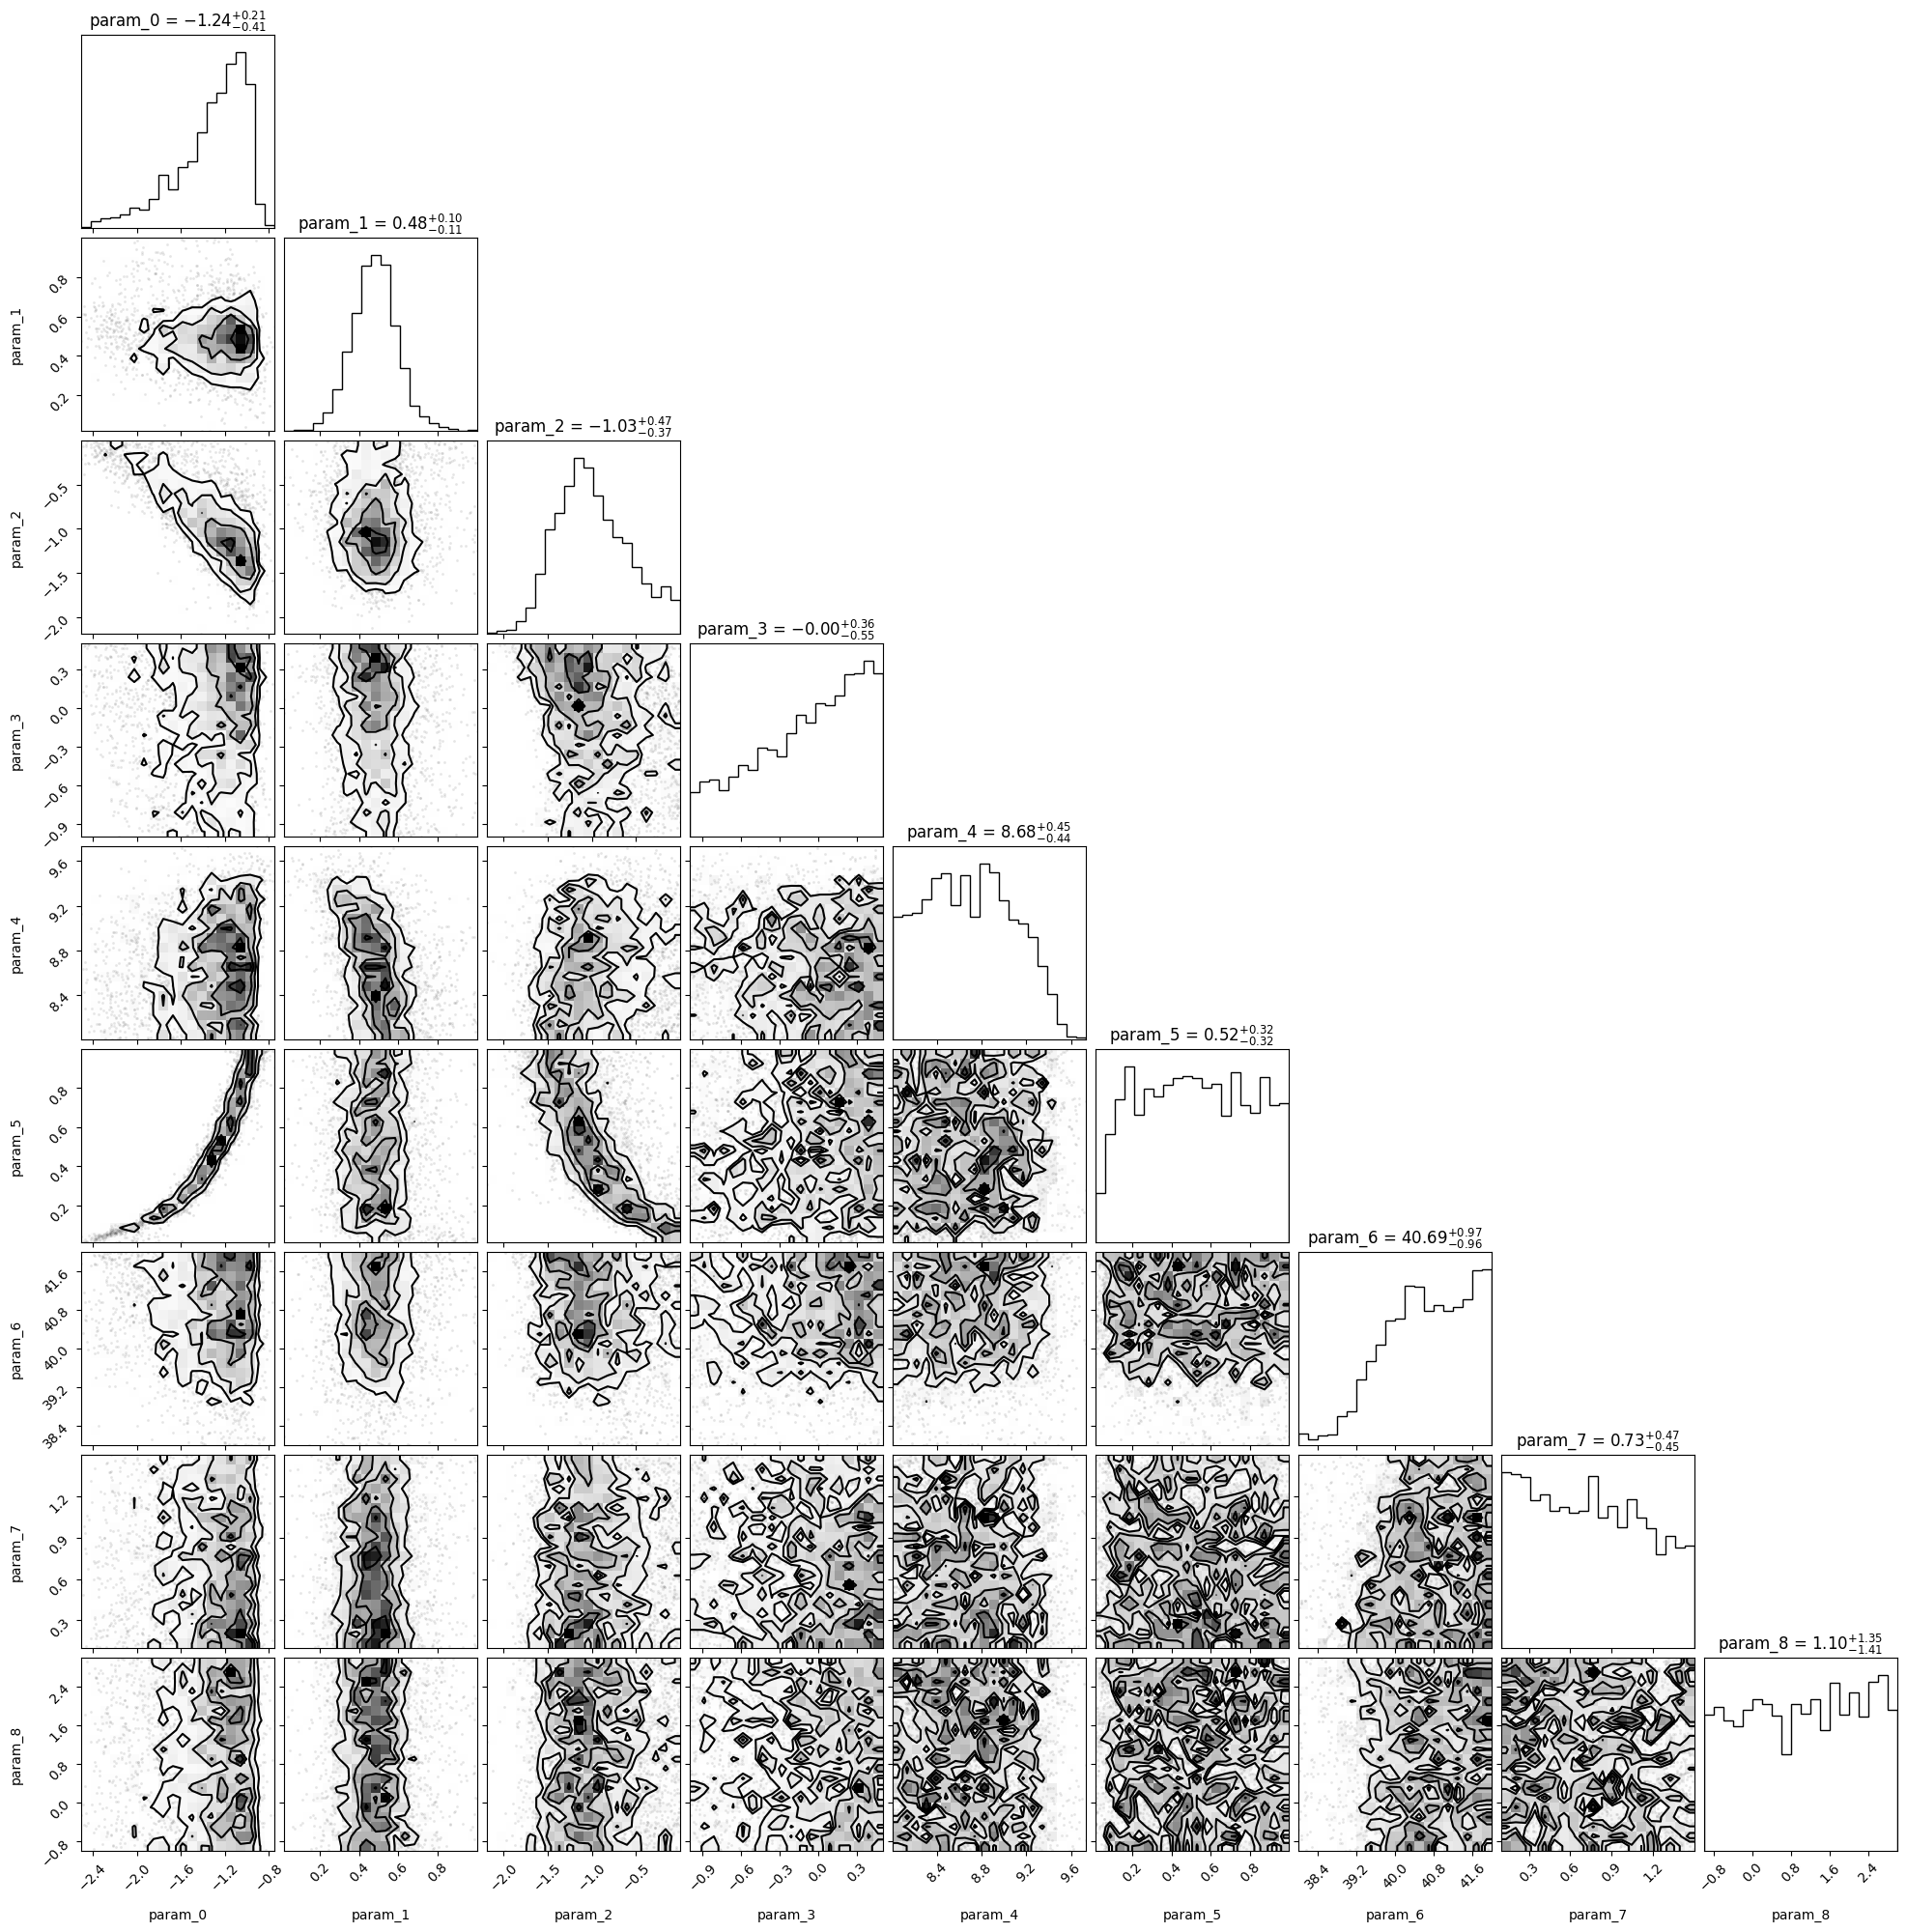

In [13]:
ultranest.plot.cornerplot(sample)

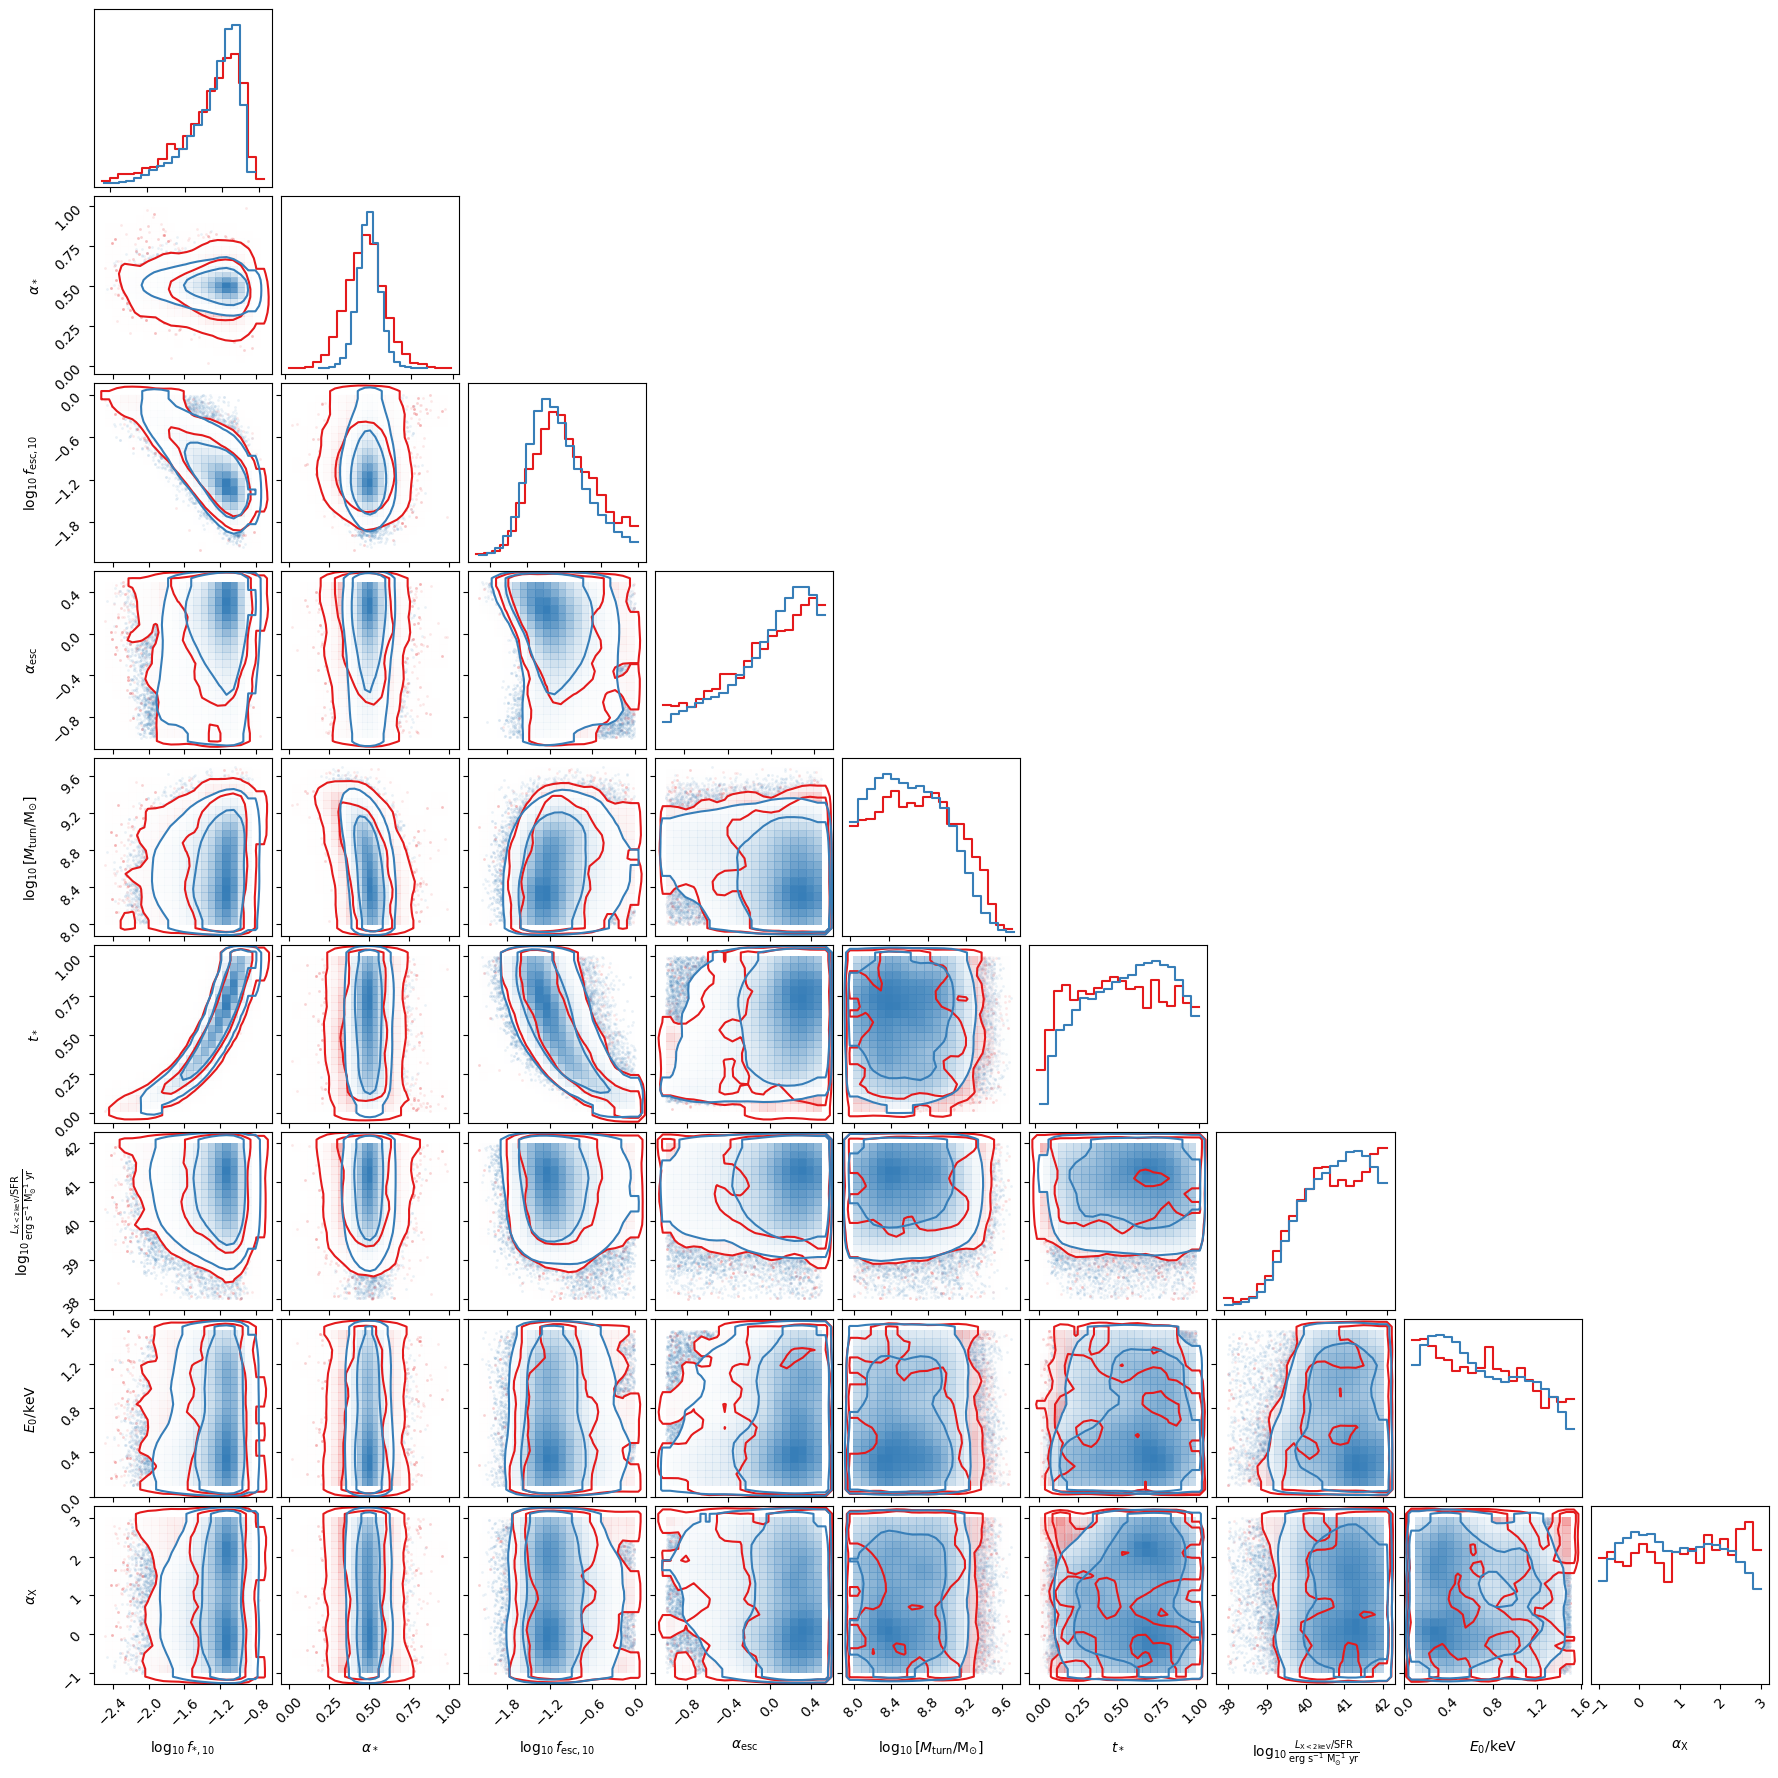

In [33]:
posterior = np.loadtxt('MultiNest/21CMMC-post_equal_weights.dat') 
plot_data = posterior[:,:-1] * (limits[:,1] - limits[:,0]) + limits[:,0]
samples = sample['samples']#['points']

fig, axs = plt.subplots(9,9, figsize=(18,18))
corner.corner(samples.reshape([-1,len(parameters)]), labels=parameters,fig=fig,
                    plot_datapoints=True, levels=[0,0.68, 0.95],smooth=1,smooth1d=0.5,
                    color='#e41a1c');

corner.corner(plot_data, labels=parameters, fig=fig, weights=np.ones(len(plot_data)) / len(plot_data)*len(samples),
                    plot_datapoints=True, levels=[0,0.68, 0.95],smooth=1,smooth1d=0.5,
                    color='#377eb8');